# machine.ipynb

This notebook applies multiple machine learning approaches to predict
transaction-level profit using the Superstore dataset.

The goal of this notebook is to explore different modeling assumptions,
evaluate their performance using validation, and justify the selection
of the two main results reported in the main notebook.

<br>
<br>

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42


In [119]:
%run parse_data.ipynb

df.head()


,Profit,Sales_amount,Quantity,Discount,Category,Sub-Category,Region,Segment,Ship Mode
0,41.9136,261.9600,2,0.00,Furniture,Bookcases,South,Consumer,Second Class
1,219.5820,731.9400,3,0.00,Furniture,Chairs,South,Consumer,Second Class
2,6.8714,14.6200,2,0.00,Office Supplies,Labels,West,Corporate,Second Class
3,-383.0310,957.5775,5,0.45,Furniture,Tables,South,Consumer,Standard Class
4,2.5164,22.3680,2,0.20,Office Supplies,Storage,South,Consumer,Standard Class


In [120]:
target = "Profit"

X = df.drop(columns=[target])
y = df[target]


In [121]:
numeric_features = [
    "Sales_amount",
    "Quantity",
    "Discount"
]

categorical_features = [
    "Segment",
    "Region",
    "Category",
    "Sub-Category",
    "Ship Mode"
]


In [122]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)


### Model comparison and validation

We compare linear baseline models with a non-linear model to evaluate
whether profit can be adequately described by linear assumptions.
We select the final model primarily by the lowest CV_RMSE (lower is better), and report test RMSE/R² as a secondary check.


In [124]:
models = {
    "Ridge (linear baseline)": Ridge(alpha=1.0),
    "Lasso (feature selection)": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    cv_rmse = -cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="neg_root_mean_squared_error",
        cv=cv
    ).mean()

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, cv_rmse, rmse, r2])

results_df = pd.DataFrame(
    results,
    columns=["Model", "CV_RMSE", "Test_RMSE", "Test_R2"]
)

results_df


,Model,CV_RMSE,Test_RMSE,Test_R2
0,Ridge (linear baseline),167.053049,294.505078,-0.788863
1,Lasso (feature selection),165.785489,282.447673,-0.645385
2,Random Forest,101.657588,227.573697,-0.068158


The Random Forest model outperforms both linear baselines (Ridge and Lasso)
in cross-validation and test performance. Random Forest has the lowest CV_RMSE (≈101.7) compared to Ridge (≈167.1) and Lasso (≈165.8), so we select it as the final model.

In [125]:
final_model = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

final_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", final_model)
])

final_pipe.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

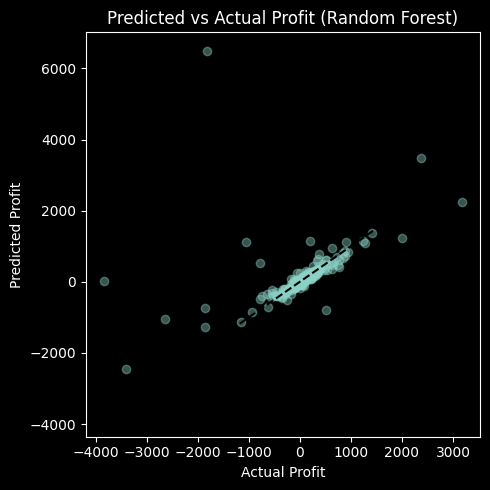

In [126]:
def pred_vs_actual_profit():
    pred = final_pipe.predict(X_test)

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, pred, alpha=0.4)
    plt.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'k--'
    )
    plt.xlabel("Actual Profit")
    plt.ylabel("Predicted Profit")
    plt.title("Predicted vs Actual Profit (Random Forest)")
    plt.tight_layout()
    plt.show()

pred_vs_actual_profit()

The Predicted vs Actual plot reveals overall model fit, bias, and the
presence of extreme profit and loss values. This diagnostic is selected as
one of the two main results reported in the main notebook.

### Feature importance

Permutation importance is used to identify which predictors contribute most
to profit prediction in the final model.


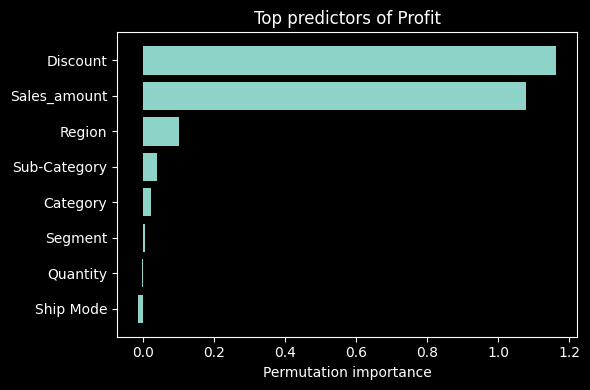

In [127]:
def perm_importance():
    feature_names = numeric_features + categorical_features

    perm = permutation_importance(
        final_pipe,
        X_test,
        y_test,
        n_repeats=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )


    imp = pd.DataFrame({
        "feature": feature_names,
        "importance": perm.importances_mean
    }).sort_values("importance", ascending=False)

    top = imp.head(8).iloc[::-1]

    plt.figure(figsize=(6,4))
    plt.barh(top["feature"], top["importance"])
    plt.xlabel("Permutation importance")
    plt.title("Top predictors of Profit")
    plt.tight_layout()
    plt.show()

perm_importance()

Permutation importance shows that discount and sales amount are the most
influential predictors of profit. This analysis is selected as the second
main result reported in the main notebook.